# Classificació d'imatges amb un model preentrenat

Com hem vist en l'exemple anterior, crear una xarxa per a la classificació d'imatges pot ser una tasca complicada. Per això, en aquest exemple, farem servir un model preentrenat per a classificar imatges. Això ens permetrà obtenir resultats molt bons sense haver de crear una xarxa des de zero.

En primer lloc veurem el seu rendiment sense afinar i, després, veurem com podem afinar-lo (_fine-tuning_) per a millorar-ne el rendiment.

## Instal·lació de l'entorn

En primer lloc, instal·lem les llibreries necessàries per a executar el codi. En el nostre cas, necessitarem `transformers`, `datasets`, `evaluate`, `accelerate`, `scikit-learn` i `accuracy`

In [2]:
%pip install --upgrade torch transformers torchvision datasets evaluate accelerate scikit-learn accuracy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 34.8 MB/s eta 0:00:00
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.20.1+cu124
    Uninstalling torchvision-0.20.1+cu124:
      Successfully uninstalled torchvision-0.20.1+cu124
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.18 requires torch<2.6,>=1.10, but you have torch 2.6.0 which is incompatible.


## Vision Transformer (ViT)

![ViT](https://huggingface.co/blog/assets/51_fine_tune_vit/vit-figure.jpg)

Els transformers de visió (ViT) són una nova arquitectura de xarxa neuronal que ha demostrat ser molt eficaç en la classificació d'imatges. Aquesta arquitectura és molt similar als transformers de llenguatge natural, però en lloc de processar seqüències de paraules, processa imatges.

Es basen en la idea de dividir la imatge en petits fragments (patches) i processar-los com si fossin tokens, agregant informació de posició a cada fragment. Això permet que la xarxa aprengui a reconèixer patrons en les imatges sense necessitat de cap capa convolucional. Una ventaja respecte a les xarxes convolucionals és que es poden detectar patrons entre parts de la imatge que no estan contigües.

Necessiten moltes dades per a entrenar-se, però, afortunadament, podem fer servir un model preentrenat per a obtenir resultats molt bons sense haver de crear una xarxa des de zero. Una vegada fet això, podem afinar-lo (_fine-tuning_) per a millorar-ne el rendiment amb moltes menys dades.

## Testejem el model preentrenat

Per fer la classificació d'imatges farem servir el model `ViT` (Vision Transformer) de Google. Aquest model ha estat preentrenat amb la base de dades `ImageNet` i ens permetrà classificar imatges amb una gran precisió.

Per veure el seu rendiment sense afinar, farem servir el model directament. Després, veurem com podem afinar-lo per a millorar-ne el rendiment.

In [3]:
# Carreguemn el dataset de Gossos i gats en el que ja hem treballat
import datasets

dataset = datasets.load_dataset('microsoft/cats_vs_dogs')
dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)

ds_train = dataset['train']
ds_test = dataset['test']

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Instanciem el model i el testejem amb una imatge d'exemple.

### Importem les llibreries

In [4]:
from transformers import pipeline, ViTFeatureExtractor, ViTForImageClassification
import matplotlib.pyplot as plt

Creem el feauture extractor. Els feature extractors són objectes que ens permeten extreure les característiques d'una imatge. Serien semblants a les capes convolucionals d'una xarxa neuronal convolucional o als tokenitzadors d'un model de llenguatge

En aquest cas, estem utilitzant un feature extractor basat en Vision Transformer. Aquest feature extractor ha estat pre-entrenat en un dataset anomenat ImageNet21k. Això vol dir que les característiques que extreu són les que ha après a partir d'aquest dataset.

In [5]:
model_name = 'google/vit-base-patch16-224'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Creem el model de classificació d'imatges. Aquest model és un classificador d'imatges basat en Vision Transformer. Aquest model ja ve amb una capa final de classificació que assigna una etiqueta a cada imatge.

In [6]:
model = ViTForImageClassification.from_pretrained(model_name)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


Creem el pipeline de classificació d'imatges. Aquest pipeline utilitza el feature extractor per extreure les característiques de les imatges i el model per classificar-les.

El pipeline ens permet classificar una imatge amb una sola crida com si fos una funció.

In [ ]:
pipeline_test = pipeline("image-classification", model=model, feature_extractor=feature_extractor, device=0)

Device set to use cpu


Testejem el ressultat del pipeline amb una imatge

Label real: dog
[{'label': 'miniature pinscher', 'score': 0.434674471616745}, {'label': 'redbone', 'score': 0.10857734829187393}, {'label': 'toy terrier', 'score': 0.09413700550794601}, {'label': 'Italian greyhound', 'score': 0.0549192950129509}, {'label': 'Rhodesian ridgeback', 'score': 0.02153707854449749}]
Label predita: miniature pinscher


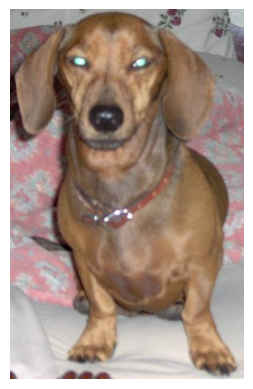

In [8]:

imatge = ds_train[20]['image']
label = ds_train[20]['labels']

# Extraiem les etiquetes de les imatges

classes = dataset['train'].features["labels"].names
resultat = pipeline_test(imatge)
print("Label real:", classes[label])

# Mostrem la label predita pel model
print(resultat)

# Tenim una llista de probabilitats per a cada classe. La classe amb la probabilitat més alta és la classe predita.

label_predita = resultat[0]['label']
print("Label predita:", label_predita)

# Mostrem la imatge
plt.imshow(imatge)
plt.axis('off')
plt.show()

Com podem veure, el model `ViT` és molt potent i la seva precisió de partida ja es molt bona. En el nostre cas massa bona, ja que les etiquetes son massa detallades (_miniature pinscher_ és un gos, pero no ens servirà per a classificar-lo com a gos) i haurem de fer _fine-tuning_ per a adapatar-lo a les nostres necessitats.

### Fine-tuning

El procediment serà molt semblant al que ja vam fer amb el model de llenguatge. Crearem un _trainer_ i l'entrenarem amb les nostres dades.

Utilitzarem "google/vit-base-patch16-224-in21k" com a model preentrenat en compte de "google/vit-base-patch16-224" perqué aquest no pot ser afinat amb tanta facilitat.

In [9]:
model_name = "google/vit-base-patch16-224-in21k"

#### Transformacions

Com a detall comentar que les transformacions que necessiten els `Vision Transformers`  (com `ViT`) són molts específiques i no les podem fer servir directament amb les que ja hem vist. Per això, farem servir les transformacions que ja venen amb el model amb el `ViTImageProcessor`.

In [10]:

from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained(model_name)

def apply_transforms(example):
    img = example['image']

    # Si la imatge no té tres canals, la convertim a RGB
    if img.mode != "RGB":
        img = img.convert("RGB")

    inputs = processor(images=img, return_tensors='pt')
    inputs["pixel_values"] = inputs["pixel_values"].squeeze(0) # remove batch dimension
    inputs["labels"] = example["labels"]
    return inputs

dataset = dataset.map(apply_transforms)
dataset.set_format(type='torch', columns=['pixel_values', 'labels'])

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Map:   0%|          | 0/18728 [00:00<?, ? examples/s]

Map:   0%|          | 0/4682 [00:00<?, ? examples/s]

In [41]:
ds_train = dataset['train']
ds_test = dataset['test']

#### Métriques

Preparem les métriques que farem servir per a avaluar el model. En aquest cas, farem servir la precisió (_accuracy_).

In [12]:
import evaluate

accuracy = evaluate.load('accuracy')

# Definim una funció per a calcular la precisió del model

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

#### Definició de les etiquetes

Abans d'entrenar el model hem de crear un diccionari que tradueixi els identificadors numèrics del sentiment a les seves etiquetes corresponents i a l'inrevés.

In [13]:
id_a_etiqueta = {i: label for i, label in enumerate(classes)}
etiqueta_a_id = {label: i for i, label in enumerate(classes)}

print(id_a_etiqueta)
print(etiqueta_a_id)

{0: 'cat', 1: 'dog'}
{'cat': 0, 'dog': 1}


#### Entrenament

Hem de definir el tamany dels blocs i el nombre d'epochs.

In [29]:
BATCH_SIZE = 16
NUM_EPOCHS = 1

In [30]:
model_fine = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(classes),
    id2label=id_a_etiqueta,
    label2id=etiqueta_a_id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

Definim els arguments d'entrenament i creem el trainer.

In [32]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="test_trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    report_to="none"
)

trainer = Trainer(
    model=model_fine,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_test,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

Finalment, executem l'entrenament. A l'igual que en el model de llenguatge, el procés pot ser llarg depenent de la quantitat de dades i de la potència del nostre hardware i es gairebé imprescindible fer servir una GPU.

In [33]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.022700,0.013474,0.996155


TrainOutput(global_step=1171, training_loss=0.03782489134856109, metrics={'train_runtime': 1078.6461, 'train_samples_per_second': 17.363, 'train_steps_per_second': 1.086, 'total_flos': 1.451269981502079e+18, 'train_loss': 0.03782489134856109, 'epoch': 1.0})

#### Testejem el model

Un cop entrenat el model, el testejem amb una imatge d'exemple.

Abans de fer proves recarregarem els datasets i no aplicarem les transformacions de data augmentation.

In [38]:
dataset = datasets.load_dataset('microsoft/cats_vs_dogs')
dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)

ds_train = dataset['train']
ds_test = dataset['test']

imatge = ds_train[20]['image']
label = ds_train[20]['labels']

Hem de recrear el pipeline de classificació d'imatges amb el model afinat.

In [39]:
pipeline_fine = pipeline("image-classification", model=model_fine, feature_extractor=feature_extractor, device=0)


Device set to use cuda:0


In [40]:
pipeline_fine(imatge)

[{'label': 'dog', 'score': 0.9979375600814819},
 {'label': 'cat', 'score': 0.0020624108146876097}]

Com podem veure, el ressultat el molt bo en tan sols una època (molt millor que en XNC) i adaptat a les nostres etiquetes.